# Topics of interest in #2020Census tweets
**By Bernardo Lopez Vicencio, [NewsCounts](https://newscounts.org/)**

We searched in #2020Census tweets for the conversation around different topics of interest. We wrote the following code that helps to find the tweets that talk about a certain word or group of words, and then we try to find different topics related to that search terms.

We find the most important words for each topic, so we can have a sense of what the topic is about.The presence of that topic is then plotted in a time series that show how the conversation has changed through time.

For this notebook we used 3 subjects related to 2020 census as an example:

* Citizenship question
* Confusion around a supposed census deadline in April
* Jobs

This code can be adapted to search for different subjects.

Please feel free to contact NewsCounts team and we can help you to use this code to search for the subjects you find interesting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
frames = []
for m in range(1,6):
    temp_df = pd.read_json(f"data/2020/all/f{m}.json",lines=False)
    temp_df["date"] = temp_df.created_at.dt.date
    temp_df["is_retweet"] = temp_df.retweeted_status.notnull()
    temp_df.drop(columns=[x for x in temp_df.columns if x not in ["id_str","date","username","text","retweet_count","is_retweet"] ]\
                 ,axis=1,inplace=True)
    frames.append(temp_df)
df = pd.concat(frames).sort_values(by=['date'])
df.reset_index(inplace = True,drop=True)
df.shape

(432309, 6)

In [3]:
def delete_rt_text(t):
    position = t.find(':')+1
    return t[position:].strip()

df.loc[df.is_retweet,"text"] = df.loc[df.is_retweet,"text"].map(lambda x: delete_rt_text(x))
df["lower_case_text"] = df.text.str.lower()

df.head()

,id_str,retweet_count,text,username,date,is_retweet,lower_case_text
0,1212165690028744704,0,Very interesting. \n\n#Census2020 \n#Politics ...,Lucas_Kastner,2020-01-01,False,very interesting. \n\n#census2020 \n#politics ...
1,1212446260591915008,0,#Arizona is almost certain to gain a congressi...,kjzzphoenix,2020-01-01,True,#arizona is almost certain to gain a congressi...
2,1212445643211526144,0,We are excited to announce that we’ve partnere...,Rockville411,2020-01-01,False,we are excited to announce that we’ve partnere...
3,1212445543433220096,0,Rural communities are among the most consisten...,MEgenealogy,2020-01-01,True,rural communities are among the most consisten...
4,1212445181687074816,2,Haitian Independence Day! To all Haitian New Y...,JulieMenin,2020-01-01,False,haitian independence day! to all haitian new y...


In [4]:
def plot_trend(data,title,column=""):
    grouped = data.groupby("date")
    if column=="":
        grouped = pd.DataFrame({"tweets": grouped["id_str"].count()})
        print(f"Days with more {title} tweets:")
        print(grouped.sort_values(["tweets"], ascending=False)["tweets"].iloc[:3])
    else:
        grouped = pd.DataFrame({"tweets": grouped[column].sum()})
        
    fig, ax = plt.subplots(1,1,figsize=(12,6))

    grouped.tweets.plot(style='-', label="All tweets",ax=ax)
    
    if column=="":
        grouped = data[data.is_retweet==True].groupby("date")
        grouped = pd.DataFrame({"tweets": grouped["id_str"].count()})
        grouped.tweets.plot(style='-', label="Retweets",ax=ax)
    
        grouped = data[data.is_retweet==False].groupby("date")
        grouped = pd.DataFrame({"tweets": grouped["id_str"].count()})
        grouped.tweets.plot(style='-', label="Original tweets",ax=ax)
    
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Count")

    ax.set_title(title)
    plt.legend();

In [5]:
from sklearn.feature_extraction import text
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

my_stop_words = text.ENGLISH_STOP_WORDS.union(["census2020","2020census","http","https","www","rt"])

def process_data(data,components_n):
    vect = CountVectorizer(stop_words=my_stop_words, min_df=4, ngram_range=(1, 2))
    X_train = vect.fit_transform(data.text)

    lda = LatentDirichletAllocation(n_components=components_n, learning_method="batch")
    X_lda = lda.fit_transform(X_train)
    large_comp_inds = np.argsort(X_lda.mean(axis=0))[::-1]
    f_names = np.array(vect.get_feature_names())
    
    return lda, X_lda, large_comp_inds, f_names

In [6]:
def plot_important_features(coef, feature_names,tn, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_ylabel("word relevance")
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")
    ax.set_title(f"Topic {tn}")

In [7]:
def plot_topics(lda, large_comp_inds,feature_names):
    components_n = len(large_comp_inds)
    print("Topics sorted by order of relevance:")
    fig, axes = plt.subplots(int(np.ceil(components_n/3)), 3, figsize=(10, 20))
    tn=0
    for ax, coef_ind in zip(axes.ravel(), large_comp_inds):
        coef = lda.components_[coef_ind]
        tn=tn+1
        plot_important_features(coef, feature_names,tn, top_n=20, ax=ax)

    plt.tight_layout()

In [8]:
def print_topic_key_words(lda, topics, feature_names, n_words=20):
    sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
    top = {}
    for i in range(len(topics)):
        top[f"Topic {i+1}"]=[]
        for j in range(n_words):
            try:
                top[f"Topic {i+1}"].append(  feature_names[sorting[topics[i], j]]  )
            except:
                pass
            
    return pd.DataFrame(top)

In [9]:
import re

def get_most_representative(tweets,data,topic):
    comp_inds = np.argsort(data.mean(axis=0))[::-1]
    
    topic = topic-1
    topic = comp_inds[topic]
    X_data = data[:,topic]
    tweets["topic_arg"] = X_data
    
    ind = np.argsort(X_data,axis=0)[::-1]
    
    return ind

def print_topic_tweets(tweets_original,data,topic,how_many=5):
    tweets = tweets_original.copy()
    print(f"Topic {topic}","\n")
    tweets["lower_case_text_2"] = tweets.lower_case_text.map(lambda x : re.sub(r'http\S+', 'url', x))
    indices = get_most_representative(tweets,data,topic)
    
    top_tweets = tweets.loc[indices,:].drop_duplicates(keep="first",subset="lower_case_text_2")
    
    for x in range(how_many):
        print(f"@{top_tweets.iloc[x].username}, from {top_tweets.iloc[x].date}")
        print(top_tweets.iloc[x].text,"\n")

In [10]:
def plot_topic_tweets(dataF, data,selected_topic,keyWords,title):
    print(f"Topic {selected_topic} key words:")
    words = keyWords[f"Topic {selected_topic}"]
    print(", ".join(list(words)))
    
    
    comp_inds = np.argsort(data.mean(axis=0))[::-1]
    
    topic = selected_topic-1
    topic = comp_inds[topic]
    X_data = data[:,topic]
    
    df_new = pd.DataFrame({"date":dataF.date,"id":dataF.id_str,"is_retweet":dataF.is_retweet,\
                           "username":dataF.username,"topic":X_data})
    
    title_plot = title + f": Topic {selected_topic} presence"
    
    return plot_trend(df_new,title_plot,"topic")

## Citizenship question

In [11]:
df_citizenship = df[df.lower_case_text.str.contains("citizen")]
df_citizenship.reset_index(inplace=True)
print(f"Number of tweets:",df_citizenship.shape[0],"\n")

Number of tweets: 7951 



Days with more Citizenship tweets:
date
2020-02-12    1136
2020-02-13     671
2020-04-01     602
Name: tweets, dtype: int64


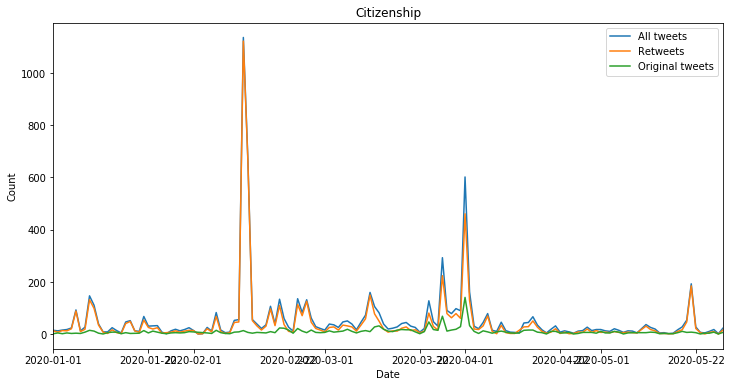

In [12]:
plot_trend(df_citizenship,"Citizenship")

Topics sorted by order of relevance:


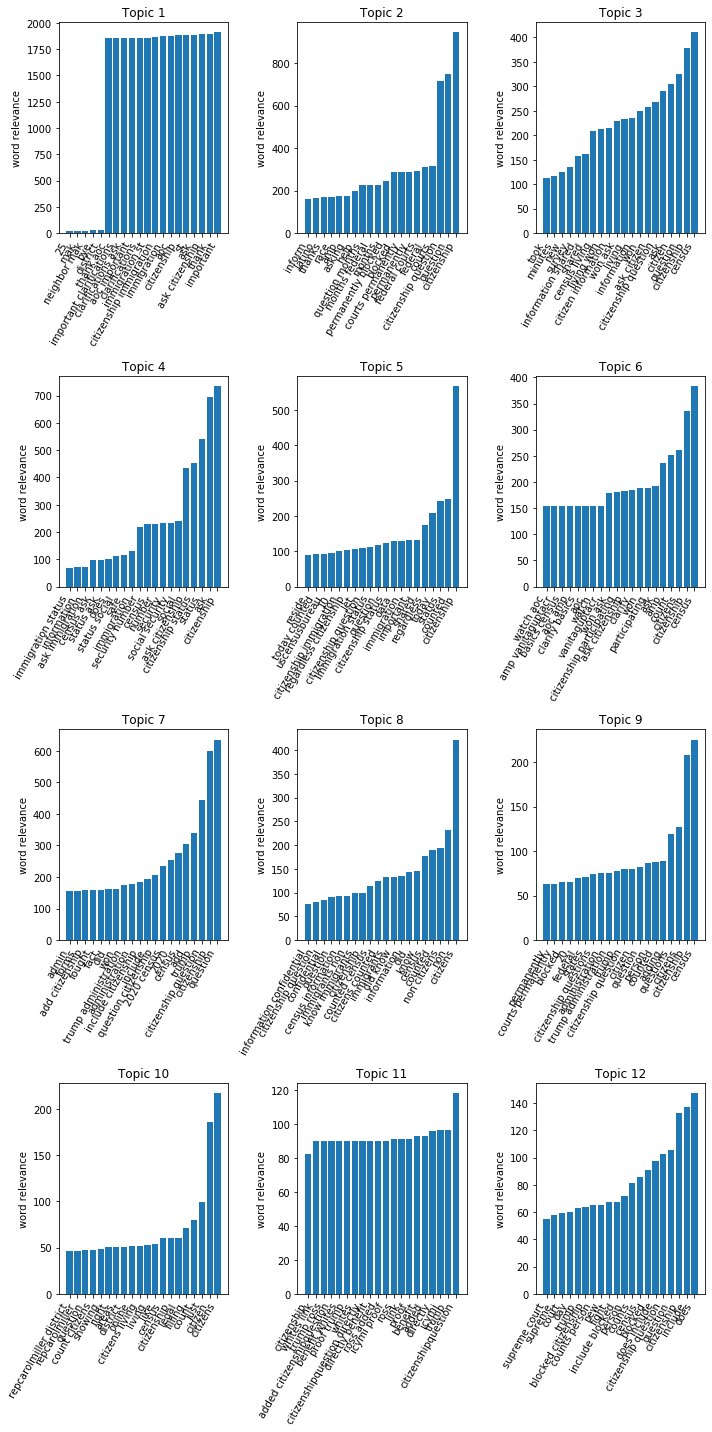

In [13]:
number_components = 12
model_lda, X_lda, inds_large_comp, feature_names = process_data(df_citizenship, number_components)

plot_topics(model_lda, inds_large_comp, feature_names)

In [14]:
key_words=print_topic_key_words(model_lda, inds_large_comp, feature_names, 20)
key_words

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12
0,important,citizenship,census,citizenship,citizenship,census,question,citizens,census,citizens,citizenshipquestion,does
1,thank,question,citizenship,ask,counted,citizenship,citizenship,non,citizenship,citizen,trump,include
2,ask citizenship,citizenship question,question,status,status,citizens,citizenship question,non citizens,citizens,just,icymi,citizenship
3,ask,courts,citizen,citizenship status,today,count,trump,counted,questions,count,directly,question
4,st,federal,ask,ask citizenship,regardless,amp,add,census,adding,filling,added,citizenship question
5,citizenship,federal courts,citizenship question,social,shared,ask,census,know,counted,legal,benefit,does include
6,aoc,permanently,ask citizen,social security,important,participating,2020,did,person,citizenship,proof,blocked
7,immigration,courts permanently,won,security,immigration,won,2020 census,information,question,census,link,census
8,citizenship immigration,blocked,information,number,data,clarify,question citizenship,did know,citizen,like,ross,counts
9,immigration st,permanently blocked,living,census,citizenship status,ask citizenship,include,immigrants,citizenship question,living,whites link,person


### Topic 1

Topic 1 key words:
important, thank, ask citizenship, ask, st, citizenship, aoc, immigration, citizenship immigration, immigration st, clarifications, aoc important, clarifications ask, important clarifications, thank aoc, district, bye, neighbor mak, mak, 25


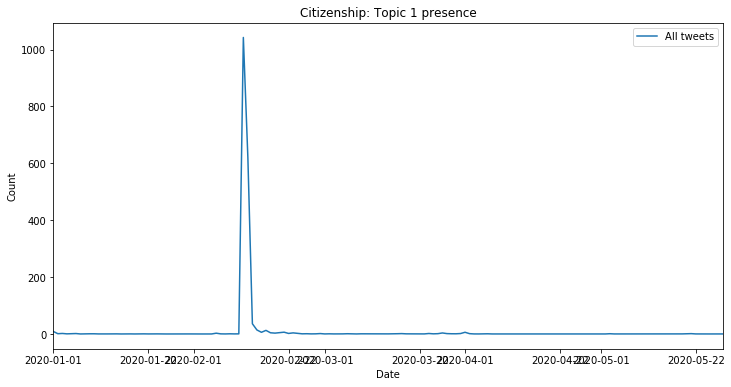

In [15]:
plot_topic_tweets(df_citizenship,X_lda,1,key_words,"Citizenship")

In [16]:
print_topic_tweets(df_citizenship,X_lda,1,10)

Topic 1 

@RyanMarsan, from 2020-02-12
Thank you, @AOC. These are important clarifications:

➡️The #2020Census will NOT ask about citizenship or immigration st… 

@vanitaguptaCR, from 2020-02-12
Thank you, @AOC. These are important clarifications:

➡️The #2020Census will NOT ask about citizenship or immigrati… https://t.co/22eO3Q4X1Y 

@NJGOPDiva, from 2020-01-03
WOW—@AOC’s district is likely comprised of 25% non-citizens. #NYC Democrats aim to redraw district maps to say bye—bye… 

@IamJohnBurnett, from 2020-01-01
WOW—@AOC’s district is likely comprised of 25% non-citizens. #NYC Democrats aim to redraw district maps to say bye—… https://t.co/FJrIxSkCp6 

@JACLChicago, from 2020-03-26
#jaclchicago, #japaneseamericans, #civilrights, #AAPI
The #2020Census WILL NOT ask you about your citizenship statu… https://t.co/zgERc4iLlh 

@cheeseandvodka, from 2020-02-12
RT vanitaguptaCR: Thank you, AOC. These are important clarifications:

➡️The #2020Census will NOT ask about citizen… https://t.co/

### Topic 2

Topic 2 key words:
citizenship, question, citizenship question, courts, federal, federal courts, permanently, courts permanently, blocked, permanently blocked, months, months federal, question months, help, asking, amp, race, thanks, latino, inform


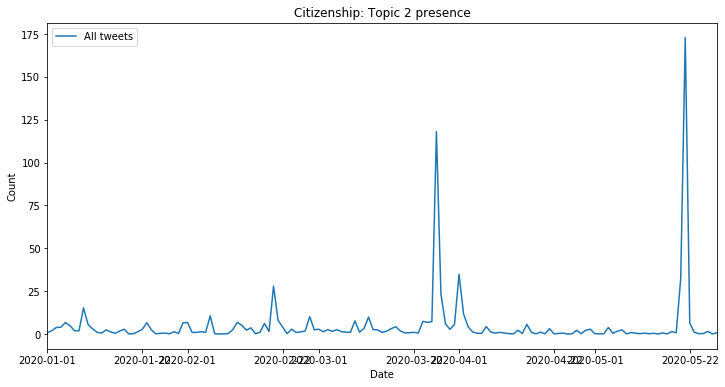

In [17]:
plot_topic_tweets(df_citizenship,X_lda,2,key_words,"Citizenship")

In [18]:
print_topic_tweets(df_citizenship,X_lda,2,10)

Topic 2 

@PAlfredFontaine, from 2020-03-27
Thanks for asking. There is NO citizenship question. Latino heritage is not citizenship. Race &amp; ethnicity help inform pro… 

@eSEy_Bee, from 2020-04-07
NEWS: DOJ finally admits that Wilbur Ross talked to Steve Bannon about the decision to demand citizenship info on the #2… 

@OpenGovCPDLRD, from 2020-01-11
The DUSA chatbot provides automated information to our audience 24/7. It can serve as a #citizenship screening tool and allo… 

@staceyabrams, from 2020-03-27
Thanks for asking. There is NO citizenship question. Latino heritage is not citizenship. Race &amp; ethnicity help info… https://t.co/HACztRQare 

@YoSoyDUSA, from 2020-01-17
The DUSA chatbot provides automated information to our audience 24/7. It can serve as a #citizenship screening tool… https://t.co/0wpATWejtY 

@ShogrenE, from 2020-04-03
The Census Bureau’s chief scientist has made an explosive claim: Even without a citizenship question, the bureau now can accura… 

@honeyisl

### Topic 3

Topic 3 key words:
census, citizenship, question, citizen, ask, citizenship question, ask citizen, won, information, living, won ask, citizen information, living won, census living, shared, information shared, survey, new, minutes, took


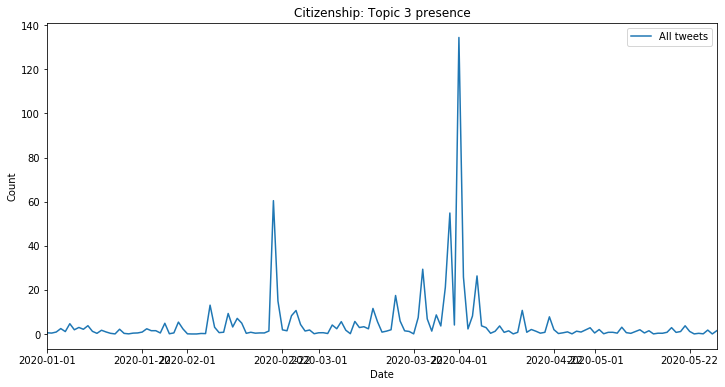

In [19]:
plot_topic_tweets(df_citizenship,X_lda,3,key_words,"Citizenship")

In [20]:
print_topic_tweets(df_citizenship,X_lda,3,10)

Topic 3 

@AngelaMSWinLA, from 2020-02-20
Nearly 7 in 10 adults think the #2020Census will include a question on citizenship—despite last year’s SCOTUS ruling prohibiti… 

@rafasanchezcruz, from 2020-02-10
Almost half of Latinos still expect citizenship question on #Census2020, according to @NALEO survey, in spite of SCOTUS bl… 

@deathtocrazy, from 2020-04-05
NEW: There is no citizenship question on the #2020Census, but Census Bureau plans to explain before 10/31 how it'll use re… 

@cpc_nyc, from 2020-03-23
NY is on pause but Census work continues! 

We are thrilled to join @JulieMenin and @CitizensUnionNY to talk about… https://t.co/AusuDhFRAE 

@JFacciponti, from 2020-03-23
NY is on pause but Census work continues! 

We are thrilled to join @JulieMenin and @CitizensUnionNY to talk about how we are… 

@theodorayuhk, from 2020-02-25
Nearly 70% of adults think the citizenship question will be included in the #2020Census, writes @theodorayuhk. (It won'… 

@hansilowang, from 2020-04-05


## April deadline

In [21]:
df_deadline = df[df.lower_case_text.str.contains("deadline") & df.lower_case_text.str.contains("april")]
df_deadline.reset_index(inplace=True)
print(f"Number of tweets:",df_deadline.shape[0],"\n")

Number of tweets: 246 



Days with more April deadline tweets:
date
2020-02-12    1136
2020-02-13     671
2020-04-01     602
Name: tweets, dtype: int64


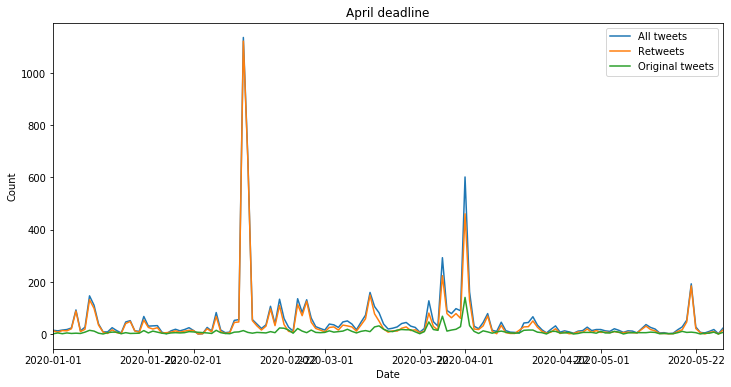

In [22]:
plot_trend(df_citizenship,"April deadline")

Topics sorted by order of relevance:


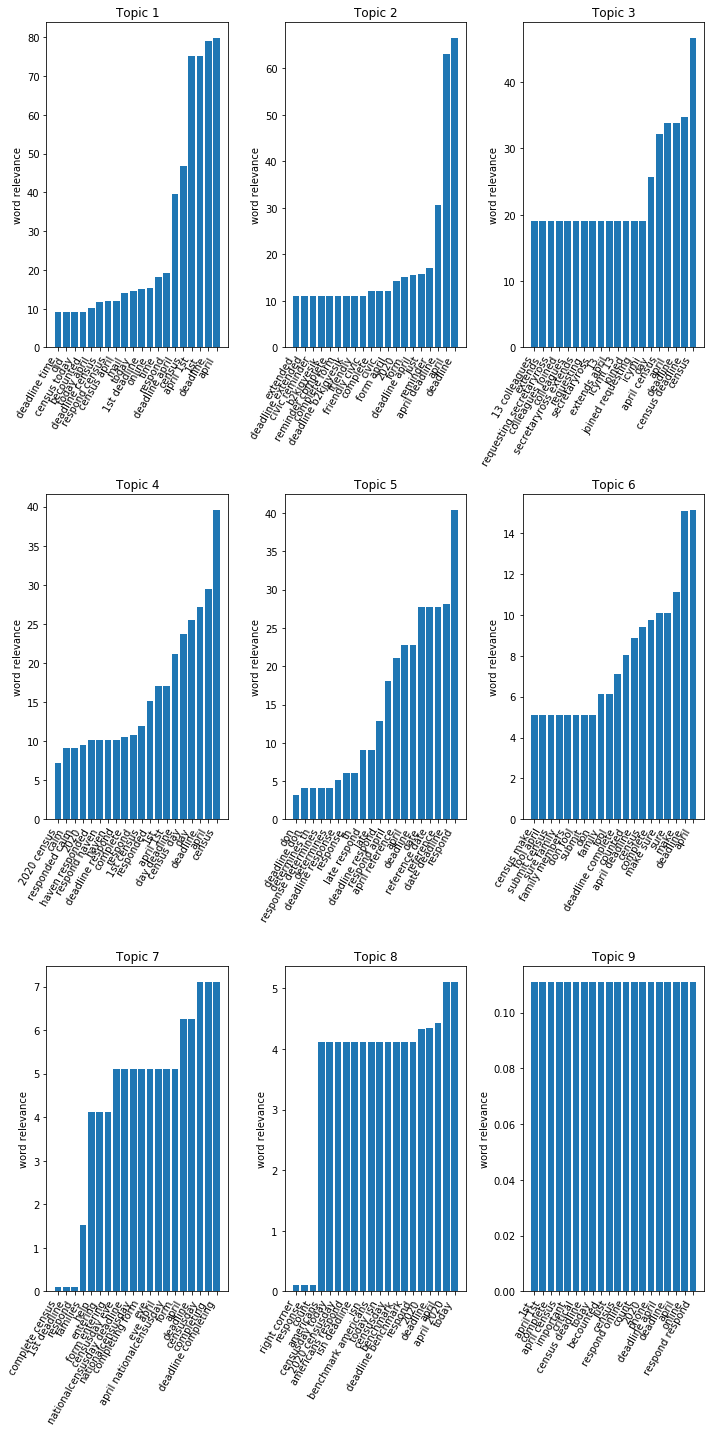

In [23]:
number_components = 9
model_lda, X_lda, inds_large_comp, feature_names = process_data(df_deadline, number_components)

plot_topics(model_lda, inds_large_comp, feature_names)

In [24]:
key_words=print_topic_key_words(model_lda, inds_large_comp, feature_names, 20)
key_words

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,april,deadline,census,census,respond,april,deadline completing,today,respond respond
1,deadline,april,census deadline,april,date deadline,deadline,completing,april 2020,online
2,1st,april deadline,deadline,deadline,reference,make,censusday,april,april
3,april 1st,reminder,april,day,reference date,sure,deadline,deadline,deadline
4,census,just,april census,census day,date,make sure,april,2020,deadline april
5,deadline april,deadline april,day,day deadline,deadline,complete,form,respond,phone
6,respond,form,extends,april 1st,april,census,censusday eve,deadline benchmark,2020
7,time,2020,requesting secretaryross,1st,april reference,april deadline,nationalcensusday deadline,benchmark,count
8,online,form april,colleagues joined,responded,respond april,counted,nationalcensusday,censusday,respond online
9,1st deadline,civic,colleagues,1st census,deadline respond,deadline complete,april nationalcensusday,americans,census


### Topic 1

Topic 1 key words:
april, deadline, 1st, april 1st, census, deadline april, respond, time, online, 1st deadline, today, mail, census april, respond census, deadline census, today april, becounted, census today, did, deadline time


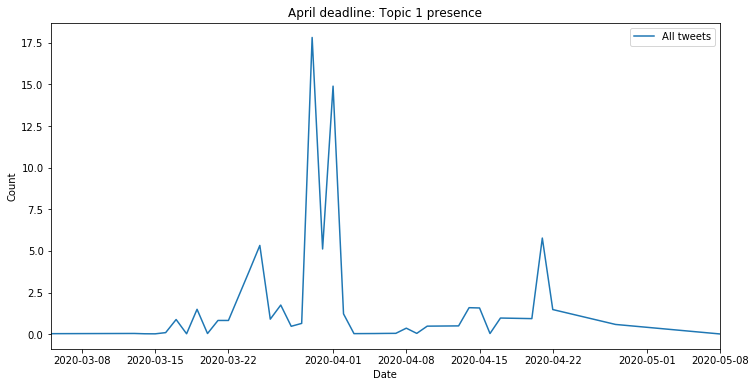

In [25]:
plot_topic_tweets(df_deadline,X_lda,1,key_words,"April deadline")

In [26]:
print_topic_tweets(df_deadline,X_lda,1,10)

Topic 1 

@PellissippiLib, from 2020-04-01
Hey @PS students, did you respond to the census? April 1st is the deadline to respond at https://t.co/bJhV5TJMnt… https://t.co/h7GgI95MY0 

@ps, from 2020-04-01
Hey @PS students, did you respond to the census? April 1st is the deadline to respond at https://t.co/bJhV5TJMnt #Pelli… 

@JostSteve, from 2020-04-21
Have you taken the census? April 1st wasn't the deadline - there is still time to take it online, by mail, or by phone! #C… 

@celindalake, from 2020-04-21
Have you taken the census? April 1st wasn't the deadline - there is still time to take it online, by mail, or by phone! #Census2020 

@PierretteGKelly, from 2020-03-25
For the first time, you can respond to the census online. Responding by mail will still be an option. Deadline is April 1st… 

@CUDennellR, from 2020-04-17
Did you know that April 1st wasn't the deadline for the #Census? In fact, it is just the first step. Here are some of the i… 

@CloseUp_DC, from 2020-04-15
Did you k

### Topic 2

Topic 2 key words:
deadline, april, april deadline, reminder, just, deadline april, form, 2020, form april, civic, complete, friendly civic, friendly, deadline b2kjgyesik, complete form, reminder complete, b2kjgyesik, civic reminder, deadline extended, extended


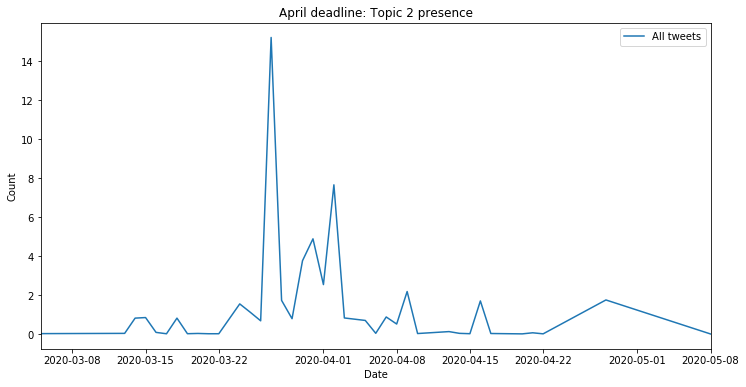

In [27]:
plot_topic_tweets(df_deadline,X_lda,2,key_words,"April deadline")

In [28]:
print_topic_tweets(df_deadline,X_lda,2,10)

Topic 2 

@drjohnmckinney, from 2020-03-27
@sincpack submitted her census information before me, but I still beat the April 1 deadline!  It took maybe 5 minutes to fill… 

@Rosenchild, from 2020-03-30
REMEMBER:

🇺🇸 #Census2020 🚨 DEADLINE: April 01, 2020

🖥️https://t.co/EaueRcFz4V

🇺🇸U.S. #Congress #Elections 2020… https://t.co/kSX1prSDA5 

@Rosenchild, from 2020-03-31
REMEMBER:

🇺🇸 #Census2020 🚨 DEADLINE: April 01, 2020

🖥️https://t.co/EaueRcFz4V

🇺🇸U.S. #Congress #Elections 2020
🇺🇸U.S. #P… 

@roshelley, from 2020-04-02
I just completed my #Census2020! April 1 not a deadline, but a benchmark. Completion deadline has been extended to April 1… 

@ForSmsd, from 2020-03-27
@sincpack submitted her census information before me, but I still beat the April 1 deadline!  It took maybe 5 minut… https://t.co/tFYUR76uY4 

@sarahkunst, from 2020-03-27
Friendly civic reminder: Please complete your #2020Census form by the April 1 deadline. https://t.co/B2kJGyesIk 

@lisasharper, from 2020-04-02
I just

### Topic 3

Topic 3 key words:
census, census deadline, deadline, april, april census, day, extends, requesting secretaryross, colleagues joined, colleagues, secretaryross, secretaryross extends, requesting, icymi, 13, extends april, icymi 13, joined, joined requesting, 13 colleagues


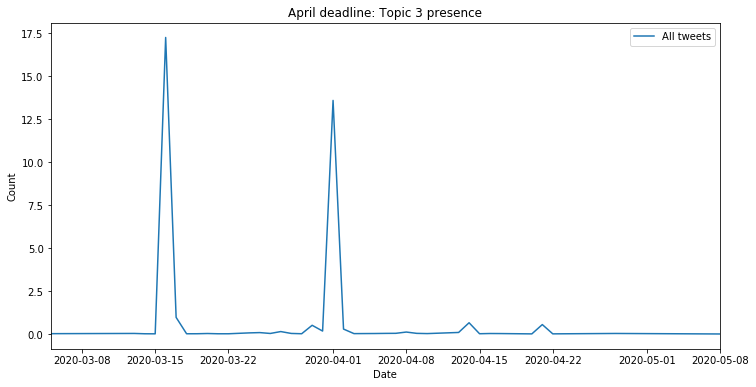

In [29]:
plot_topic_tweets(df_deadline,X_lda,3,key_words,"April deadline")

In [30]:
print_topic_tweets(df_deadline,X_lda,3,10)

Topic 3 

@ABoR_REALTORS, from 2020-04-01
#DYK that April 1 is Census Day, a key reference date for the 2020 Census—NOT a deadline? Use this day to determine wh… 

@NARRealtorParty, from 2020-04-01
#DYK that April 1 is Census Day, a key reference date for the 2020 Census—NOT a deadline? Use this day to determine… https://t.co/KGyMljqzAR 

@CLLAROQueSi, from 2020-04-01
April 1:This is Census Day, a key reference date for the 2020 Census—not a deadline.We use this day to determine wh… https://t.co/VbbaRRo0nB 

@CPLCapitanas, from 2020-04-01
April 1:This is Census Day, a key reference date for the 2020 Census—not a deadline.We use this day to determine who is co… 

@theJayAquino, from 2020-03-16
ICYMI— 13 of my colleagues joined me in requesting that @SecretaryRoss extends the April 1 #Census deadline.

The nati… 

@RepYvetteClarke, from 2020-03-16
ICYMI— 13 of my colleagues joined me in requesting that @SecretaryRoss extends the April 1 #Census deadline.

The n… https://t.co/ERLQYBy4WH 


## Jobs

In [31]:
df_jobs = df[df.lower_case_text.str.contains("job")]
df_jobs.reset_index(inplace=True)
print(f"Number of tweets:",df_jobs.shape[0],"\n")

Number of tweets: 4137 



Days with more Jobs tweets:
date
2020-02-06    175
2020-02-13    173
2020-02-12    118
Name: tweets, dtype: int64


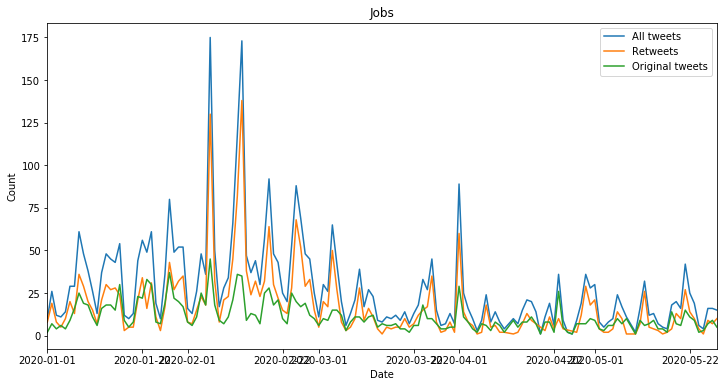

In [32]:
plot_trend(df_jobs,"Jobs")

Topics sorted by order of relevance:


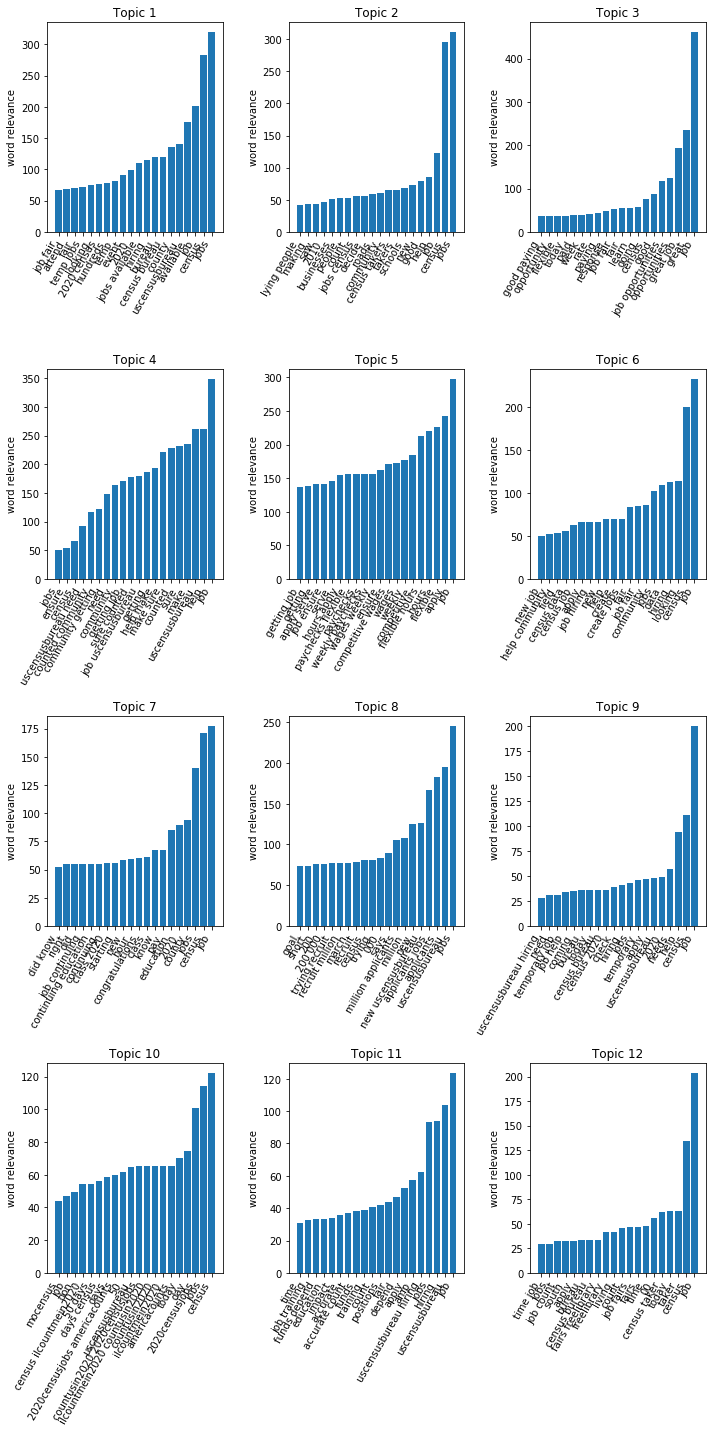

In [33]:
number_components = 12
model_lda, X_lda, inds_large_comp, feature_names = process_data(df_jobs, number_components)

plot_topics(model_lda, inds_large_comp, feature_names)

In [34]:
key_words=print_topic_key_words(model_lda, inds_large_comp, feature_names, 20)
key_words

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12
0,jobs,jobs,job,job,job,job,job,jobs,job,census,job,job
1,census,census,great,help,apply,census,census,uscensusbureau,census,jobs,uscensusbureau,census
2,job,job,great job,uscensusbureau,flexible,looking,jobs,applicants,help,2020censusjobs,hiring,taker
3,available,help,opportunities,make,hours,hiring,county,applicants jobs,needs,day,jobs,today
4,uscensusbureau,good,job opportunities,sure,flexible hours,data,2020,new uscensusbureau,2020,today,uscensusbureau hiring,census taker
5,county,new,good,counted,competitive,jobs,education,new,uscensusbureau,americacounts,amp,00
6,census bureau,schools,census,make sure,weekly,community,pay,million,apply,ilcountmein2020,apply,time
7,bureau,takers,doing,help make,wages,job fair,know,million applicants,temporary,countusin2020,depend,fairs
8,hiring,census takers,learn,getting,competitive wages,fair,class,says,jobs,ilcountmein2020 countusin2020,fair,job fairs
9,jobs available,community,fair,job uscensusbureau,ensure,create jobs,congratulations,000,hiring,countusin2020 2020censusjobs,positions,count


### Topic 1

Topic 1 key words:
jobs, census, job, available, uscensusbureau, county, census bureau, bureau, hiring, jobs available, 2020, event, temp, hundreds, 2020 census, looking, temp jobs, fair, attend, job fair


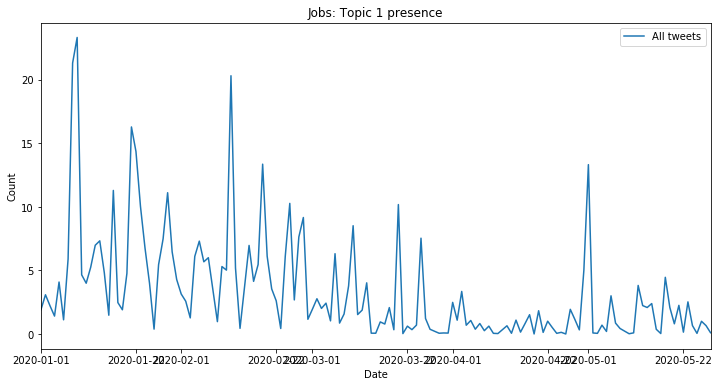

In [35]:
plot_topic_tweets(df_jobs,X_lda,1,key_words,"Jobs")

In [36]:
print_topic_tweets(df_jobs,X_lda,1,10)

Topic 1 

@HOTWorkforce, from 2020-01-06
Hundreds of U.S. #Census Bureau temp jobs available! Attend hiring event at the Hill County Workforce Solutions Cen… https://t.co/iO5ApTULXW 

@CensusPK, from 2020-02-19
Hundreds of U.S. #Census Bureau temp jobs available! Attend hiring event at the Hill County Workforce Solutions Center on… 

@CensusPK, from 2020-01-05
Hundreds of U.S. #Census Bureau temp jobs available! Attend hiring event at the McLennan County Workforce Solutions Cente… 

@HOTWorkforce, from 2020-01-04
Hundreds of U.S. #Census Bureau temp jobs available! Attend hiring event at the Falls County Workforce Solutions Ce… https://t.co/EWUXvStvxo 

@CensusPK, from 2020-02-18
Hundreds of U.S. #Census Bureau temp jobs available! Attend hiring event at the Falls County Workforce Solutions Center o… 

@brown_weinraub, from 2020-01-22
Join CAMBA at the 2020 Census Job Fair on Friday, January 24th. There you can apply for a job, volunteer with a census commit… 

@SatyaForMadison, from 2

### Topic 2

Topic 2 key words:
jobs, census, job, help, good, new, schools, takers, census takers, community, roads, decide, jobs census, count, people, businesses, 2010, saw, making, lying people


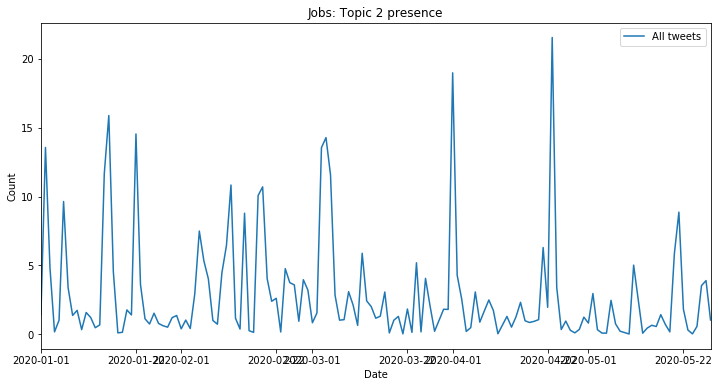

In [37]:
plot_topic_tweets(df_jobs,X_lda,2,key_words,"Jobs")

In [38]:
print_topic_tweets(df_jobs,X_lda,2,10)

Topic 2 

@John_Foti, from 2020-01-06
New decade, new census! 

#Census2020 will help decide how billions of dollars impact:

📚Schools
🚗Roads
🏡Housing
💼Jobs
🏥Ho… 

@Elizabe29017938, from 2020-05-11
Great job, El Paso!  Our Census self-response rate is higher than the Texas average.  Haven’t taken the Census yet?  It’… 

@ELPCensus2020, from 2020-05-11
Great job, El Paso!  Our Census self-response rate is higher than the Texas average.  Haven’t taken the Census yet?… https://t.co/urZcsV5ph6 

@FBIPhiladelphia, from 2020-01-15
We saw it with the 2010 Census: scammers lying to people about the availability of jobs as census takers, and charging fees to hel… 

@AINColorado, from 2020-04-09
Businesses use population statistics to help decide where to add jobs or open new stores, offices or other business… https://t.co/QY9vpIYISz 

@stephen29897939, from 2020-05-21
#DYK population statistics are used to determine where to add jobs, or open more stores or offices? Responses to the #20… 

@Liz

### Topic 3

Topic 3 key words:
job, great, great job, opportunities, job opportunities, good, census, doing, learn, fair, job fair, response, paying, rate, week, paid, today, flexible, opportunity, good paying


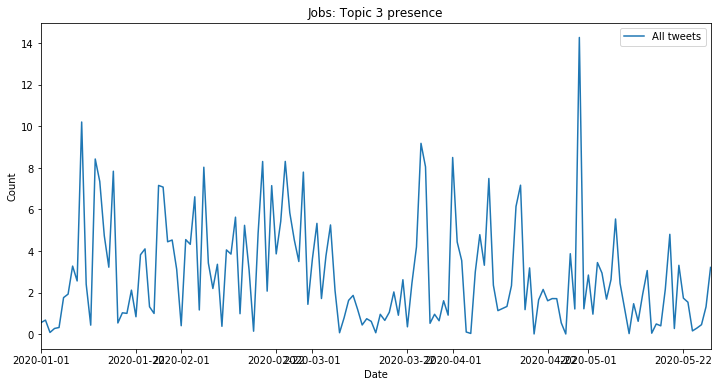

In [39]:
plot_topic_tweets(df_jobs,X_lda,3,key_words,"Jobs")

In [40]:
print_topic_tweets(df_jobs,X_lda,3,10)

Topic 3 

@1icevice, from 2020-03-25
Great job so far Erie County residents: I've learned our #Census2020 response rate is better than the state and national… 

@PublicHealthMDC, from 2020-02-22
Learn about good paying #2020Census job opportunities in the Madison area! 
✔️$22+ per hour
✔️Flexible hours
✔️Paid trai… 

@analiss, from 2020-04-29
We have been doing a great job filling out our census forms. Top 10 in New York State is a good start, now let’s get i… 

@markpoloncarz, from 2020-03-24
Great job so far Erie County residents: I've learned our #Census2020 response rate is better than the state and nat… https://t.co/TxEhEG5p0h 

@CityofMadison, from 2020-03-05
Learn about good paying #2020Census job opportunities in the Madison area! 
✔️$22+ per hour
✔️Flexible hours
✔️Paid… https://t.co/i3WrhdatCy 

@AkronOhioMayor, from 2020-02-06
Looking for a little extra income? Go check out the #Census2020 Job Fair at the Akron Urban League and learn about how yo… 

@Tippyd2, from 2020-01-27